# CARICAMENTO DATASET

## Import e Caricamento Dati

In [12]:
import pandas as pd
import numpy as np

df = pd.read_csv("master.csv")
print("Dataset caricato con successo.")

print("\n--- Anteprima dataset ---")
display(df.head())

print("\n--- Info dataset ---")
display(df.info())

print("\n--- Statistiche descrittive dataset ---")
display(df.describe())

print("\n--- Conteggio valori nulli ---")
display(df.isna().sum())

Dataset caricato con successo.

--- Anteprima dataset ---


,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers



--- Info dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             27820 non-null  object 
 1   year                27820 non-null  int64  
 2   sex                 27820 non-null  object 
 3   age                 27820 non-null  object 
 4   suicides_no         27820 non-null  int64  
 5   population          27820 non-null  int64  
 6   suicides/100k pop   27820 non-null  float64
 7   country-year        27820 non-null  object 
 8   HDI for year        8364 non-null   float64
 9    gdp_for_year ($)   27820 non-null  object 
 10  gdp_per_capita ($)  27820 non-null  int64  
 11  generation          27820 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 2.5+ MB


None


--- Statistiche descrittive dataset ---


,year,suicides_no,population,suicides/100k pop,HDI for year,gdp_per_capita ($)
count,27820.000000,27820.000000,2.782000e+04,27820.000000,8364.000000,27820.000000
mean,2001.258375,242.574407,1.844794e+06,12.816097,0.776601,16866.464414
std,8.469055,902.047917,3.911779e+06,18.961511,0.093367,18887.576472
min,1985.000000,0.000000,2.780000e+02,0.000000,0.483000,251.000000
25%,1995.000000,3.000000,9.749850e+04,0.920000,0.713000,3447.000000
50%,2002.000000,25.000000,4.301500e+05,5.990000,0.779000,9372.000000
75%,2008.000000,131.000000,1.486143e+06,16.620000,0.855000,24874.000000
max,2016.000000,22338.000000,4.380521e+07,224.970000,0.944000,126352.000000



--- Conteggio valori nulli ---


country                   0
year                      0
sex                       0
age                       0
suicides_no               0
population                0
suicides/100k pop         0
country-year              0
HDI for year          19456
 gdp_for_year ($)         0
gdp_per_capita ($)        0
generation                0
dtype: int64

### Note per la gestione:
- HDI for year -> ha valori nulli -> controlliamo (cerco anche cos'è perché non lo so)
- gdp_for_year ($) -> ha le "" e le , -> da stringa a numero
- age -> da gestire gli interalli
- country-year -> colonna inutile

## Data Cleaning

In [13]:
# Normalizzo i nomi colonne -> rimuovo spazi iniziali/finali
df = df.rename(columns=lambda x: x.strip())
for c in df.columns:
    print(repr(c))

'country'
'year'
'sex'
'age'
'suicides_no'
'population'
'suicides/100k pop'
'country-year'
'HDI for year'
'gdp_for_year ($)'
'gdp_per_capita ($)'
'generation'


In [14]:
df_clean = df.copy()

### Pulizia colonne

In [15]:
# --- Pulizia colonne di tipo dato ---

#  gdp_for_year ($) ha stringhe tipo "2,156,624,900" -> rimuovo "" e converto il PIL in numero
df_clean["gdp_for_year ($)"] = (df["gdp_for_year ($)"].astype(str).str.replace(",", "").astype(float))

# ------------------------------------------------------------------------------------

# --- Pulizia colonne di tipo stringa ---
str_cols = ["country", "sex", "generation", "country-year"]

for col in str_cols:
    df_clean[col] = (df[col].astype(str).str.strip().str.replace(r"\s+", " ", regex=True))

### Pulizia colonna 'age'

In [16]:
df_clean["age"] = (df["age"].str.strip().str.replace(" years", "", regex=False)) # -> ora ho solo gli intervalli come stringhe

def age_to_midpoint(a):
    if "-" in a:
        low, high = a.split("-")
        return (int(low) + int(high)) / 2 # 15-25 -> 20
    if a.endswith("+"):
        return float(a.replace("+", "")) + 5  # 75+ -> 80
    return np.nan

df_clean["age_mid"] = df_clean["age"].apply(age_to_midpoint)

In [17]:
# Creo una variabile 'age_group' numerica (1–6) per i grafici

age_order = ["5-14", "15-24", "25-34","35-54", "55-74", "75+"]
df_clean["age_cat"] = pd.Categorical(df_clean["age"], categories=age_order, ordered=True)

df_clean["age_group_id"] = df_clean["age_cat"].cat.codes + 1

# 'age' e 'age_cat' si ripetono a questo punto
df_clean = df_clean.drop(columns=["age"])

### Gestione dei valori mancanti ('HDI for year')

HDI è l'acronimo di "Human Development Index", ovvero l'Indice di Sviluppo Umano, un indicatore creato dal Programma delle Nazioni Unite per lo Sviluppo (UNDP) per misurare il benessere di una nazione. Questo indice non considera solo il PIL pro capite, ma anche la speranza di vita e il livello di istruzione (anni medi di istruzione).
- Scopo: Valutare lo sviluppo e il benessere di un paese in modo più completo rispetto ai soli dati economici.
- Componenti:
    - Salute: Misurata dalla speranza di vita alla nascita.
    - Istruzione: Valutata in base agli anni medi di istruzione.
    - Reddito: Determinata dal PIL pro capite.
- Utilizzo: Viene utilizzato per classificare i paesi in quattro gruppi (molto alto, alto, medio, basso) e per monitorare i progressi nel tempo. 


In [18]:
# Per ogni paese, calcolo la media dell’HDI dove è presente poi riempio i valori mancanti dello stesso paese con quella media.
df_clean["HDI for year"] = df.groupby("country")["HDI for year"].transform(lambda x: x.fillna(x.mean()))

# Riempio i NaN rimasti con la media globale dell'HDI.
df_clean["HDI for year"] = df_clean["HDI for year"].fillna(df_clean["HDI for year"].mean())

### Elimino la colonna country-years

In [19]:
# Abbiamo già country e year separati
df_clean = df_clean.drop(columns=["country-year"])

### Tolgo eventuali duplicati

In [20]:
df_clean = df_clean.drop_duplicates()

### Controllo aggiornato

In [21]:
print("AGGIORNAMENTO DATASET POST-PULIZIA")

print("\n--- Anteprima dataset ---")
display(df_clean.head())

print("\n--- Info dataset ---")
display(df_clean.info())

print("\n--- Statistiche descrittive dataset ---")
display(df_clean.describe())

print("\n--- Conteggio valori nulli ---")
display(df_clean.isna().sum())

AGGIORNAMENTO DATASET POST-PULIZIA

--- Anteprima dataset ---


,country,year,sex,suicides_no,population,suicides/100k pop,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation,age_mid,age_cat,age_group_id
0,Albania,1987,male,21,312900,6.71,0.673,2.156625e+09,796,Generation X,19.5,15-24,2
1,Albania,1987,male,16,308000,5.19,0.673,2.156625e+09,796,Silent,44.5,35-54,4
2,Albania,1987,female,14,289700,4.83,0.673,2.156625e+09,796,Generation X,19.5,15-24,2
3,Albania,1987,male,1,21800,4.59,0.673,2.156625e+09,796,G.I. Generation,80.0,75+,6
4,Albania,1987,male,9,274300,3.28,0.673,2.156625e+09,796,Boomers,29.5,25-34,3



--- Info dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   country             27820 non-null  object  
 1   year                27820 non-null  int64   
 2   sex                 27820 non-null  object  
 3   suicides_no         27820 non-null  int64   
 4   population          27820 non-null  int64   
 5   suicides/100k pop   27820 non-null  float64 
 6   HDI for year        27820 non-null  float64 
 7   gdp_for_year ($)    27820 non-null  float64 
 8   gdp_per_capita ($)  27820 non-null  int64   
 9   generation          27820 non-null  object  
 10  age_mid             27820 non-null  float64 
 11  age_cat             27820 non-null  category
 12  age_group_id        27820 non-null  int8    
dtypes: category(1), float64(4), int64(4), int8(1), object(3)
memory usage: 2.4+ MB


None


--- Statistiche descrittive dataset ---


,year,suicides_no,population,suicides/100k pop,HDI for year,gdp_for_year ($),gdp_per_capita ($),age_mid,age_group_id
count,27820.000000,27820.000000,2.782000e+04,27820.000000,27820.000000,2.782000e+04,27820.000000,27820.00000,27820.000000
mean,2001.258375,242.574407,1.844794e+06,12.816097,0.774271,4.455810e+11,16866.464414,41.28652,3.502876
std,8.469055,902.047917,3.911779e+06,18.961511,0.085048,1.453610e+12,18887.576472,24.72942,1.706730
min,1985.000000,0.000000,2.780000e+02,0.000000,0.483000,4.691962e+07,251.000000,9.50000,1.000000
25%,1995.000000,3.000000,9.749850e+04,0.920000,0.713200,8.985353e+09,3447.000000,19.50000,2.000000
50%,2002.000000,25.000000,4.301500e+05,5.990000,0.774271,4.811469e+10,9372.000000,44.50000,4.000000
75%,2008.000000,131.000000,1.486143e+06,16.620000,0.849000,2.602024e+11,24874.000000,64.50000,5.000000
max,2016.000000,22338.000000,4.380521e+07,224.970000,0.944000,1.812071e+13,126352.000000,80.00000,6.000000



--- Conteggio valori nulli ---


country               0
year                  0
sex                   0
suicides_no           0
population            0
suicides/100k pop     0
HDI for year          0
gdp_for_year ($)      0
gdp_per_capita ($)    0
generation            0
age_mid               0
age_cat               0
age_group_id          0
dtype: int64

# PAIRPLOT

<Figure size 1400x1400 with 0 Axes>

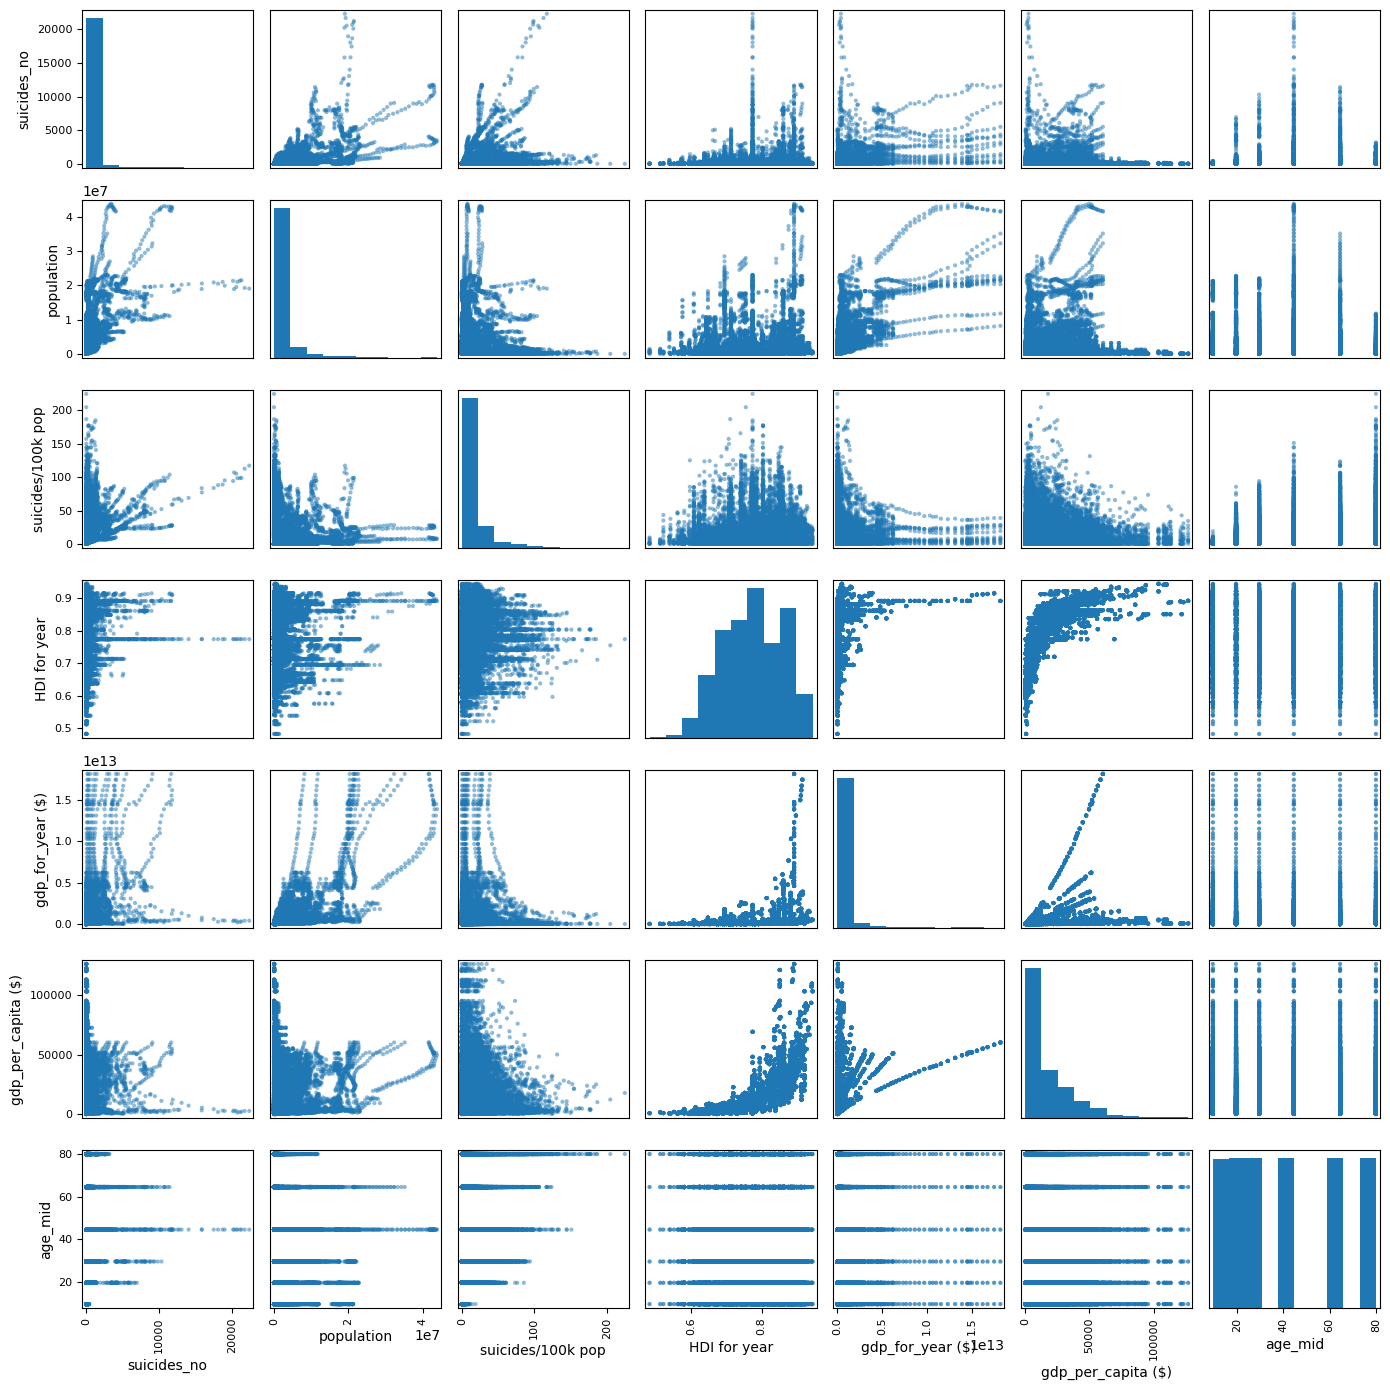

In [22]:
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

numeric_cols = [
    "suicides_no",
    "population",
    "suicides/100k pop",
    "HDI for year",
    "gdp_for_year ($)",
    "gdp_per_capita ($)",
    "age_mid"
]

plt.figure(figsize=(14, 14))
scatter_matrix(df_clean[numeric_cols], figsize=(14, 14), diagonal='hist')
plt.tight_layout()
plt.show()